In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithZScore, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_oversamling.csv')
data.head()

,userId,wine,rate
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1
1,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1
2,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
3,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
4,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithZSore (KNNWithZScore):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithZScore.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithZScore.fit(self, trainset_fold)
            train_prediction = KNNWithZScore.test(self, trainset_fold.build_testset())
            prediction = KNNWithZScore.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithZScore.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithZScore SGD

* knn_with_zscore cosine, user based

In [4]:
knn_with_zscore = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore.create_reader(data)
predictions = knn_with_zscore.fit()
#acc
metrics = knn_with_zscore.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2576
RMSE: 0.6633
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2609
RMSE: 0.6193
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2381
RMSE: 0.6912
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2467
RMSE: 0.6820
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2624
RMSE: 0.6612
###############################################
The Results are: 

Average RMSE on Training Set: 0.2531347188524007
Average RMSE on Test Set: 0.6634248946984281
RMSE: 0.6522
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6522388699423879
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6522
MAE:  0.3506
MSE: 0.4254
Precision: 0.33
Recall: 0.30
the acc is 70.87


/tmp/ipykernel_18821/1944145904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [5]:
knn_with_zscore2 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore2.create_reader(data)
predictions = knn_with_zscore2.fit()
#acc
metrics = knn_with_zscore2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3455
RMSE: 0.7298
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3395
RMSE: 0.6468
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3161
RMSE: 0.7239
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3352
RMSE: 0.6420
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3400
RMSE: 0.6896
###############################################
The Results are: 

Average RMSE on Training Set: 0.3352558405690119
Average RMSE on Test Set: 0.6864388916422858
RMSE: 0.6692
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6691949846349475
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6692
MAE:  0.3834
MSE: 0.4478
Precision: 0.30
Recall: 0.24
the acc is 69.29


/tmp/ipykernel_18821/2949601189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2949601189.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [6]:
knn_with_zscore3 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore3.create_reader(data)
predictions = knn_with_zscore3.fit()
#acc
metrics = knn_with_zscore3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2159
RMSE: 0.6493
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1708
RMSE: 0.6579
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2108
RMSE: 0.6226
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2096
RMSE: 0.6260
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2152
RMSE: 0.6745
###############################################
The Results are: 

Average RMSE on Training Set: 0.2044452902649998
Average RMSE on Test Set: 0.6460492347364785
RMSE: 0.6611
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6610613514891909
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6611
MAE:  0.3381
MSE: 0.4370
Precision: 0.31
Recall: 0.27
the acc is 72.97


/tmp/ipykernel_18821/2711717971.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2711717971.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared diference, item based

In [7]:
knn_with_zscore4 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore4.create_reader(data)
predictions = knn_with_zscore4.fit()
#acc
metrics = knn_with_zscore4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2820
RMSE: 0.6633
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2920
RMSE: 0.6125
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3015
RMSE: 0.6447
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2962
RMSE: 0.6418
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2747
RMSE: 0.7881
###############################################
The Results are: 

Average RMSE on Training Set: 0.2892652138020383
Average RMSE on Test Set: 0.6700760161511379
RMSE: 0.7448
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7448159141418653
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7448
MAE:  0.4182
MSE: 0.5548
Precision: 0.29
Recall: 0.21
the acc is 69.82


/tmp/ipykernel_18821/2579909233.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2579909233.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson, user based

In [8]:
knn_with_zscore5 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore5.create_reader(data)
predictions = knn_with_zscore5.fit()
#acc
metrics = knn_with_zscore5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2040
RMSE: 0.6043
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2043
RMSE: 0.6977
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2029
RMSE: 0.6028
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1303
RMSE: 0.6712
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1968
RMSE: 0.6555
###############################################
The Results are: 

Average RMSE on Training Set: 0.18768090186210362
Average RMSE on Test Set: 0.6463219902144067
RMSE: 0.6957
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6957273493881725
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6957
MAE:  0.3589
MSE: 0.4840
Precision: 0.35
Recall: 0.32
the acc is 73.23


/tmp/ipykernel_18821/2335934697.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2335934697.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_zscore6 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore6.create_reader(data)
predictions = knn_with_zscore6.fit()
#acc
metrics = knn_with_zscore6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1607
RMSE: 0.5546
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1489
RMSE: 0.7454
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1584
RMSE: 0.6546
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1425
RMSE: 0.6355
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1771
RMSE: 0.6177
###############################################
The Results are: 

Average RMSE on Training Set: 0.15754098693710983
Average RMSE on Test Set: 0.6415787870803787
RMSE: 0.6921
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6921014058724716
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6921
MAE:  0.3094
MSE: 0.4790
Precision: 0.46
Recall: 0.41
the acc is 76.38


/tmp/ipykernel_18821/3850417117.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/3850417117.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_zscore7 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore7.create_reader(data)
predictions = knn_with_zscore7.fit()
#acc
metrics = knn_with_zscore7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1813
RMSE: 0.6762
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1313
RMSE: 0.7212
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1737
RMSE: 0.6465
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1636
RMSE: 0.6302
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1751
RMSE: 0.5939
###############################################
The Results are: 

Average RMSE on Training Set: 0.16496631513497123
Average RMSE on Test Set: 0.6535917530750269
RMSE: 0.5436
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5435731154603016
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18821/2496457707.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2496457707.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_zscore8 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore8.create_reader(data)
predictions = knn_with_zscore8.fit()
#acc
metrics = knn_with_zscore8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1694
RMSE: 0.6378
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1643
RMSE: 0.6349
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1397
RMSE: 0.7239
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1587
RMSE: 0.6023
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1565
RMSE: 0.5960
###############################################
The Results are: 

Average RMSE on Training Set: 0.15772927170033285
Average RMSE on Test Set: 0.6389800145324795
RMSE: 0.5787
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5787469281069235
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18821/1008673265.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/1008673265.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithZScore Alternating Least Squares (ALS)

* knn_with_zscore cosine, user based

In [12]:
knn_with_zscore9 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore9.create_reader(data)
predictions = knn_with_zscore9.fit()
#acc
metrics = knn_with_zscore9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2928
RMSE: 0.5835
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2875
RMSE: 0.6044
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2613
RMSE: 0.7185
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2663
RMSE: 0.6190
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2679
RMSE: 0.7501
###############################################
The Results are: 

Average RMSE on Training Set: 0.2751806474569089
Average RMSE on Test Set: 0.6551069759825293
RMSE: 0.6749
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6749332972767075
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6749
MAE:  0.3817
MSE: 0.4555
Precision: 0.43
Recall: 0.38
the acc is 67.45


/tmp/ipykernel_18821/2936597747.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2936597747.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [13]:
knn_with_zscore10 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore10.create_reader(data)
predictions = knn_with_zscore10.fit()
#acc
metrics = knn_with_zscore10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3195
RMSE: 0.7157
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3254
RMSE: 0.6592
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3233
RMSE: 0.5755
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3090
RMSE: 0.7089
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3151
RMSE: 0.6999
###############################################
The Results are: 

Average RMSE on Training Set: 0.3184598514241323
Average RMSE on Test Set: 0.6718459100147357
RMSE: 0.7440
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7439555747723254
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7440
MAE:  0.4137
MSE: 0.5535
Precision: 0.33
Recall: 0.29
the acc is 68.50


/tmp/ipykernel_18821/1654456447.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/1654456447.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [14]:
knn_with_zscore11 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore11.create_reader(data)
predictions = knn_with_zscore11.fit()
#acc
metrics = knn_with_zscore11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2211
RMSE: 0.6517
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2172
RMSE: 0.6538
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2210
RMSE: 0.6263
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2197
RMSE: 0.6270
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1938
RMSE: 0.6587
###############################################
The Results are: 

Average RMSE on Training Set: 0.2145675690572811
Average RMSE on Test Set: 0.6435246916093469
RMSE: 0.6504
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6504318565792627
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6504
MAE:  0.3257
MSE: 0.4231
Precision: 0.39
Recall: 0.34
the acc is 74.54


/tmp/ipykernel_18821/2380454897.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2380454897.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, item based

In [15]:
knn_with_zscore12 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore12.create_reader(data)
predictions = knn_with_zscore12.fit()
#acc
metrics = knn_with_zscore12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2673
RMSE: 0.7454
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2770
RMSE: 0.6451
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2686
RMSE: 0.6464
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2637
RMSE: 0.6583
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2818
RMSE: 0.6105
###############################################
The Results are: 

Average RMSE on Training Set: 0.2716809836260049
Average RMSE on Test Set: 0.6611454148030782
RMSE: 0.7126
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7126013655879474
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7126
MAE:  0.3744
MSE: 0.5078
Precision: 0.32
Recall: 0.28
the acc is 73.49


/tmp/ipykernel_18821/3404645186.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/3404645186.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, user based

In [16]:
knn_with_zscore13 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore13.create_reader(data)
predictions = knn_with_zscore13.fit()
#acc
metrics = knn_with_zscore13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1830
RMSE: 0.5956
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1471
RMSE: 0.6534
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1757
RMSE: 0.5431
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1916
RMSE: 0.6333
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1699
RMSE: 0.6196
###############################################
The Results are: 

Average RMSE on Training Set: 0.17345650148652872
Average RMSE on Test Set: 0.609018321176014
RMSE: 0.6299
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6298772324080163
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6299
MAE:  0.3236
MSE: 0.3967
Precision: 0.33
Recall: 0.29
the acc is 73.75


/tmp/ipykernel_18821/1814740321.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/1814740321.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, item based

In [17]:
knn_with_zscore14 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore14.create_reader(data)
predictions = knn_with_zscore14.fit()
#acc
metrics = knn_with_zscore14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1662
RMSE: 0.6594
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2190
RMSE: 0.5743
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2000
RMSE: 0.7003
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1886
RMSE: 0.5719
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2280
RMSE: 0.6500
###############################################
The Results are: 

Average RMSE on Training Set: 0.20033969138064514
Average RMSE on Test Set: 0.6311640091460042
RMSE: 0.6695
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6694547564411086
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6695
MAE:  0.3466
MSE: 0.4482
Precision: 0.35
Recall: 0.28
the acc is 72.97


/tmp/ipykernel_18821/1740756307.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/1740756307.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_zscore15 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore15.create_reader(data)
predictions = knn_with_zscore15.fit()
#acc
metrics = knn_with_zscore15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1797
RMSE: 0.6133
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1864
RMSE: 0.5552
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1897
RMSE: 0.5093
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1859
RMSE: 0.5934
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1166
RMSE: 0.7668
###############################################
The Results are: 

Average RMSE on Training Set: 0.1716699130077794
Average RMSE on Test Set: 0.6076165015600854
RMSE: 0.6693
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6693363192337386
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18821/2066309904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/2066309904.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_zscore16 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore16.create_reader(data)
predictions = knn_with_zscore16.fit()
#acc
metrics = knn_with_zscore16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1801
RMSE: 0.7084
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2030
RMSE: 0.5437
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2058
RMSE: 0.5254
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1658
RMSE: 0.6890
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2010
RMSE: 0.6214
###############################################
The Results are: 

Average RMSE on Training Set: 0.19114769519246327
Average RMSE on Test Set: 0.6175652059324318
RMSE: 0.6698
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6698107684904291
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18821/3669178657.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18821/3669178657.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
6,7,KnnWithZSore,(shrunk) pearson corr coeff,SGD,True,0.543573,0.273811,0.295472,0.414510,0.364511,75.590551
7,8,KnnWithZSore,(shrunk) pearson corr coeff,SGD,False,0.578747,0.282910,0.334948,0.331325,0.288862,76.377953
12,13,KnnWithZSore,pearson corr coeff,ALS,True,0.629877,0.323586,0.396745,0.327715,0.285175,73.753281
10,11,KnnWithZSore,MSD,ALS,True,0.650432,0.325737,0.423062,0.393137,0.337810,74.540682
0,1,KnnWithZSore,Cosine,SGD,True,0.652239,0.350622,0.425416,0.328614,0.295540,70.866142
2,3,KnnWithZSore,MSD,SGD,True,0.661061,0.338139,0.437002,0.309253,0.267820,72.965879
1,2,KnnWithZSore,Cosine,SGD,False,0.669195,0.383353,0.447822,0.297333,0.239541,69.291339
14,15,KnnWithZSore,(shrunk) pearson corr coeff,ALS,True,0.669336,0.340562,0.448011,0.276335,0.229335,71.653543
13,14,KnnWithZSore,pearson corr coeff,ALS,False,0.669455,0.346555,0.448170,0.350610,0.282138,72.965879
15,16,KnnWithZSore,(shrunk) pearson corr coeff,ALS,False,0.669811,0.380512,0.448646,0.335000,0.282683,70.078740


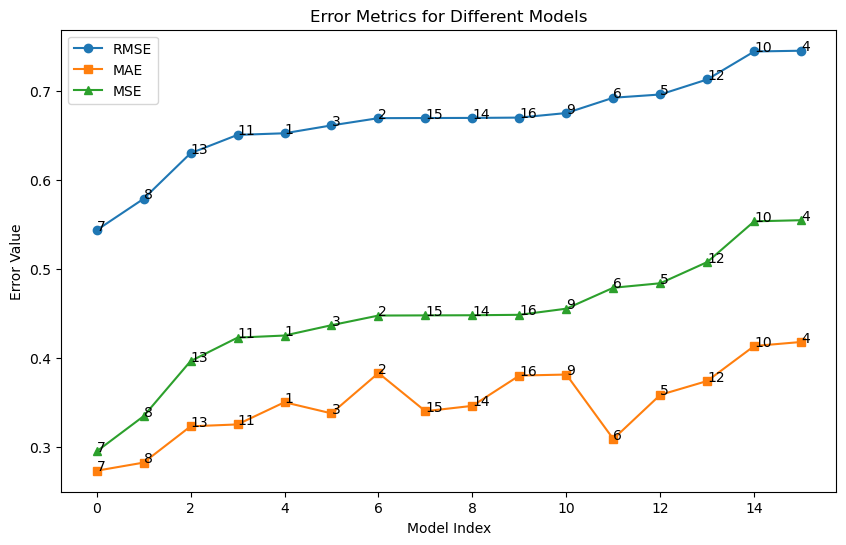

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

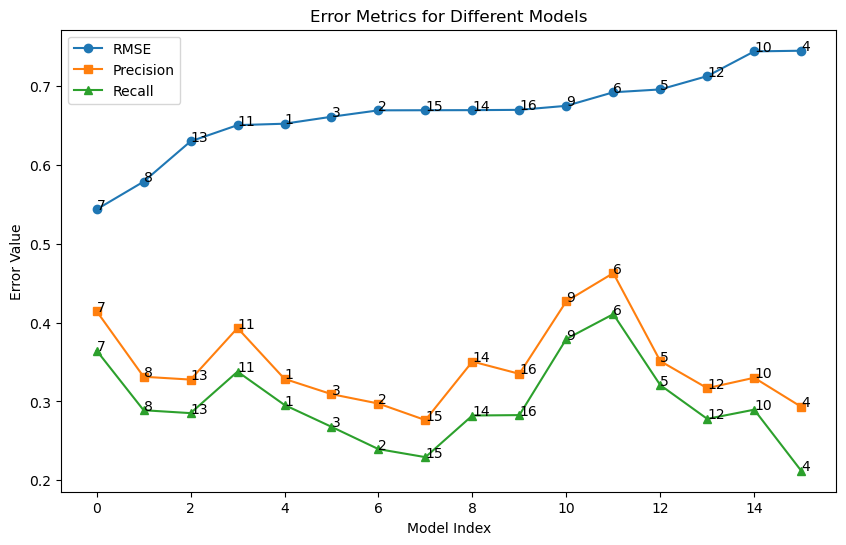

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

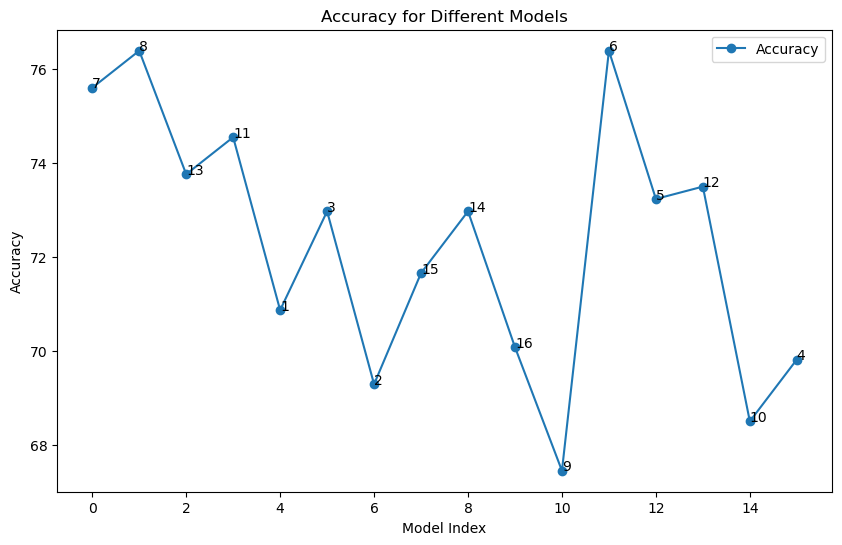

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_zscore.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Relais de Patache d'Aux
2. Item ID: Petit Chablis
3. Item ID: Les Pierrelles Crozes-Hermitage
4. Item ID: Senorino de Baldios
5. Item ID: Chenin Blanc Secateurs
6. Item ID: LFE900
7. Item ID: Chenin Blanc Secateurs
8. Item ID: Les Fossiles Riesling
9. Item ID: Yellow Label 
10. Item ID: Lodi California


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_zscore.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5
2. User ID: 9a3cc655-c88e-4c1b-95e2-add7579ff4c2
3. User ID: 918cd9b7-8057-4106-8f7f-9e9e3a423fb1
4. User ID: 91cf68cc-9436-43e1-871d-33beef4d2337
5. User ID: 91cf68cc-9436-43e1-871d-33beef4d2337
6. User ID: 9c85a219-a94e-4b78-b300-ea65e52e9c6e


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_zscore.get_neighbors_uid(user_id=5)

['bc79b0e3-064d-4240-86de-e86499f577e8',
 '2a62eecd-b0cd-4395-9f8c-7c912a208be2',
 '5ccd8030-047b-432c-a630-d784ab415756',
 '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7',
 '7e32fee4-f7c4-4600-8a34-db7801ac79d5',
 'bec96c0b-5b0b-4992-8756-e0d3b704afb5',
 'ff89d8c1-48a3-49b5-af95-62d0ce9ecf55',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 'ecc462e1-5041-43ca-94c3-c2bfc9b3215e',
 '20e0b694-84a5-4f11-9191-598f924c2947']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_zscore.get_neighbors_iid(item_id=20)

['2/5 大亂鬥 2',
 'Tempranillo',
 'La Moneta Gavi',
 'Fleurie Grand Pre',
 'Pas Dosé',
 'Saar-Riesling Brut',
 'Morandina Valpolicella Ripasso Superiore',
 'Full of Joy Weissburgunder',
 'Le Difese',
 'Bordeaux']

In [28]:
knn_with_zscore.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_zscore.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 14 with sim 0.000000000000000
And the baseline estimate is: 3.674172673948214

#####

Note: If the baseline is 3.0418032786885245 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_zscore.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 9,4.0,2.97377,"{'was_impossible': True, 'reason': 'User and/o...",81,1,1.02623
1,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Diablo black cabernet sauvignin,5.0,5.00000,"{'actual_k': 34, 'was_impossible': False}",54,2,0.00000
2,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1.0,1.00000,"{'actual_k': 11, 'was_impossible': False}",12,11,0.00000
3,5ccd8030-047b-432c-a630-d784ab415756,Koonunga Hill Shiraz - Cabernet,3.0,2.97377,"{'was_impossible': True, 'reason': 'User and/o...",120,1,0.02623
4,99654a70-c3bb-46f4-8697-b9345482e48d,Red (Winemaker's Blend),4.0,2.97377,"{'was_impossible': True, 'reason': 'User and/o...",2,0,1.02623
5,be0e69e3-30d5-4e21-b62f-05402fbfcd5a,Piceno Bacchus,5.0,5.00000,"{'actual_k': 5, 'was_impossible': False}",4,3,0.00000
6,bc79b0e3-064d-4240-86de-e86499f577e8,La Rocca Soave Classico,5.0,5.00000,"{'actual_k': 22, 'was_impossible': False}",81,0,0.00000
7,3dd9219a-c64e-4c5a-a61b-aad6a417a69a,Brachetto Piemonte,3.0,3.00000,"{'actual_k': 1, 'was_impossible': False}",1,5,0.00000
8,bc79b0e3-064d-4240-86de-e86499f577e8,Dominique Gruhier,4.0,2.97377,"{'was_impossible': True, 'reason': 'User and/o...",81,0,1.02623
9,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1.0,1.00000,"{'actual_k': 40, 'was_impossible': False}",120,12,0.00000


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
190,defee34b-7775-4889-b703-92b730d85e70,Zamò Bianco,5.0,5.0,"{'actual_k': 3, 'was_impossible': False}",15,3,0.0
138,3b1f7bc8-6a23-47e5-97df-043bd1b97f12,White cava,2.0,2.0,"{'actual_k': 3, 'was_impossible': False}",3,3,0.0
140,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",81,14,0.0
308,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1.0,1.0,"{'actual_k': 10, 'was_impossible': False}",7,7,0.0
307,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Lodi California,2.0,2.0,"{'actual_k': 40, 'was_impossible': False}",67,1,0.0
146,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,1.0,"{'actual_k': 19, 'was_impossible': False}",18,18,0.0
147,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Chateau les bouysses,5.0,5.0,"{'actual_k': 34, 'was_impossible': False}",54,3,0.0
149,dc90e649-113d-4cec-983e-d03a7d4acff3,Cabernet Sauvignon,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,5,0.0
305,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,1.0,"{'actual_k': 19, 'was_impossible': False}",19,19,0.0
152,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",46,11,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
285,00324bc3-0b35-4051-bc6d-9c258a4252c2,Ettore germano riesling,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.026230
150,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",4,1,2.026230
306,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",4,1,2.026230
107,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Organic pinot grigio terre siciliane igt,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",54,1,2.026230
139,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Metodo Classico Pas Dosé,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",71,1,2.026230
313,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Jam shed malbec,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",54,1,2.026230
248,86ddb2c4-016f-47ed-8cf9-aa0a3564b7f8,Puntalice,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",2,2,2.026230
37,b0fbc6bd-4b1e-48cd-92f3-f49b7a505941,Terra d'Eclano Aglianico Irpinia,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",4,1,2.026230
249,7c63488a-31b5-4389-9526-d4c6030652aa,Rubesco Rosso di Torgiano,5.0,2.973770,"{'was_impossible': True, 'reason': 'User and/o...",2,2,2.026230
290,df904a46-c461-4233-9d44-6ac11a8bbddc,Chianti,4.0,1.590909,"{'actual_k': 0, 'was_impossible': False}",4,19,2.409091
